In [ ]:
!pip install langchain langgraph langchain_community langchain_groq tiktoken

In [ ]:
!pip install langchain_huggingface langchain_astradb

In [75]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
embeddings

HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [76]:
from langchain_astradb import AstraDBVectorStore
from google.colab import userdata

vector_store = AstraDBVectorStore(
    collection_name="langgraph_chatbot",
    embedding=embeddings,
    api_endpoint=userdata.get('ASTRA_DB_API_ENDPOINT'),
    token=userdata.get('ASTRA_DB_APPLICATION_TOKEN'),
    namespace="default_keyspace",
)

In [99]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://langchain-ai.github.io/langgraph/concepts/",
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/"
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size = 800, chunk_overlap = 200)
final_docs = text_splitter.split_documents(doc_list)

In [ ]:
vector_store.add_documents(final_docs)

In [77]:
retriever = vector_store.as_retriever(top_k_results=5)

In [78]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [79]:
class RouteQuery(BaseModel):
  datasource : Literal["vectorstore", "wiki_search"] = Field(
      description = "Given a user data, route it to wiki search or vector store"
  )

In [80]:
from langchain_groq import ChatGroq
groq_api_key = userdata.get('GROQ_API_KEY')
llm = ChatGroq(model="llama-3.1-70b-versatile", groq_api_key = groq_api_key)

In [81]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [82]:
sys_prompt = """
You are an expert at routing a user question to wiki search or vector store.
The vector store contains information about LangGraph and it's concepts only.
Use the vector store on these topics othervise use wiki search.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
      ("system", sys_prompt),
      ("user", "{question}")
    ]
)
router = route_prompt | structured_llm_router

In [83]:
router.invoke({"question": "What is React js?"}).datasource

'wiki_search'

In [ ]:
!pip install wikipedia

In [85]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
wiki_wrapper = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [100]:
wiki.invoke("What is react js")

'Page: React (software)\nSummary: React (also known as React.js or ReactJS) is a free and open-source front-end JavaScript library that aims to make building user interfaces based on components more "se'

In [86]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  question: str
  generation: str
  documents: List[str]
  chat_history: str

In [87]:
def retrieve(state):
  print('----RETRIEVAL----')
  question = state["question"]
  docs = retriever.invoke(question)
  ret_docs = ["".join([doc.page_content for doc in docs])]
  state["chat_history"] += f"User: {state['question']}\n"
  return {"documents":ret_docs, "question":question, "chat_history": state["chat_history"]}

def wiki_search(state):
  print('----WIKI SEARCH----')
  question = state["question"]
  #print(question)
  wiki_docs = wiki.invoke(question)
  #print(wiki_docs)
  state["chat_history"] += f"User: {state['question']}\n"
  return {"documents":wiki_docs, "question":question, "chat_history": state["chat_history"]}

def route_ques(state):
  print('----ROUTING QUERY----')
  question = state["question"]
  datasource = router.invoke(question).datasource
  if datasource == "vectorstore":
    return "vectorstore"
  elif datasource == "wiki_search":
    return "wiki_search"
  else:
    print("----ROUTING FAILED----")

In [88]:
def generate_answer(state):
  print('----GENERATING ANSWER----')
  groq_api_key = userdata.get('GROQ_API_KEY')
  llm_ans = ChatGroq(model="llama-3.1-70b-versatile", groq_api_key=groq_api_key)
  prompt_template = ChatPromptTemplate.from_template(
      """
  Use the following pieces of context to answer the question at the end.
  If you don't know the answer, just say that you don't know, don't try to make up an answer.
  Answer in brief.

  {context}

  Question: {question}
  Answer:"""
  )
  prompt = prompt_template.format_prompt(context=state["documents"], question=state["question"])
  #print(prompt)
  answer = llm_ans.invoke(prompt)
  state["chat_history"] += f"Assistant: {answer.content}\n"
  return {"generation": answer, "question": state["question"], "chat_history": state["chat_history"]}

In [94]:
def reformulate_question(state):
    print('----REFORMULATING QUESTION----')
    groq_api_key = userdata.get('GROQ_API_KEY')
    llm_ref = ChatGroq(model="llama-3.1-70b-versatile", groq_api_key=groq_api_key)
    #print(state["chat_history"])
    template = ChatPromptTemplate.from_template(
    """
    Given a chat history and the latest user question
    which might or might not reference a context in the chat history
    formulate a standalone question that can be understood without referencing the chat history
    Do not answer the question, just reformulate it and return it as it it is

    chat history: {chat_history}
    question: {question}
    """)

    #print(state["chat_history"])
    prompt_ref = template.format_prompt(chat_history=state["chat_history"], question=state["question"])
    #print(prompt_ref)
    reformulated_question = llm_ref.invoke(prompt_ref)
    state["question"] = reformulated_question.content.strip()

    return state

In [95]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieve)
graph.add_node("wiki_search", wiki_search)
graph.add_node("reformulate_question", reformulate_question)
graph.add_edge(START, "reformulate_question")

graph.add_conditional_edges(
    "reformulate_question",
    route_ques,
    {
        "vectorstore": "retrieve",
        "wiki_search": "wiki_search"
    }
)

graph.add_node("generate_answer", generate_answer)
graph.add_edge("retrieve", "generate_answer")
graph.add_edge("wiki_search", "generate_answer")
graph.add_edge("generate_answer", END)

app = graph.compile()

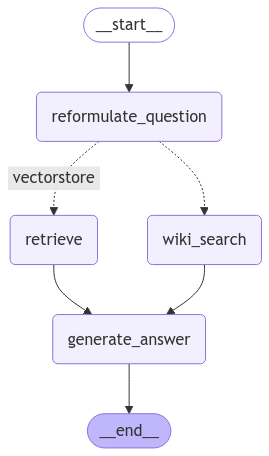

In [96]:
from IPython.display import display, Image
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [98]:
chat_history = ""  # Initialize chat history outside the loop
while True:
    question = input("Enter your question (or type 'exit' to quit): ")
    if question.lower() == "exit":
        break

    input_data = {"question": question, "chat_history": chat_history}
    for final_state in app.stream(input_data):
        pass

    print("Assistant:", final_state["generate_answer"]["generation"].content)
    chat_history = final_state["generate_answer"]["chat_history"]

Enter your question (or type 'exit' to quit): what is react js
----REFORMULATING QUESTION----
----ROUTING QUERY----
----WIKI SEARCH----
----GENERATING ANSWER----
Assistant: A free and open-source front-end JavaScript library for building user interfaces based on components.
Enter your question (or type 'exit' to quit): what language is it written in?
----REFORMULATING QUESTION----
----ROUTING QUERY----
----WIKI SEARCH----
----GENERATING ANSWER----
Assistant: JavaScript.
Enter your question (or type 'exit' to quit): what is langgraph?
----REFORMULATING QUESTION----
----ROUTING QUERY----
----RETRIEVAL----
----GENERATING ANSWER----
Assistant: LangGraph is a library for building stateful, multi-actor applications with Large Language Models (LLMs), particularly useful for creating agent and multi-agent workflows.
Enter your question (or type 'exit' to quit): how is it different from langchain?
----REFORMULATING QUESTION----
----ROUTING QUERY----
----RETRIEVAL----
----GENERATING ANSWER----
A